In [1]:
using Plots, PlotThemes, LaTeXStrings
using OffsetArrays
using LinearAlgebra
using FFTW
using StatsBase
using Unitful
using Base: Fix1, Fix2
using Distributions
using ArbNumerics
using Trapz

pyplot()

theme(:mute)
default(;palette=:seaborn_deep6, fontfamily="serif")
j=im

imsize = (500,350)

(500, 350)

In [2]:
S = OffsetArray(sqrt(13/6).*[0, 0, 1+j, 0, 0, 0, -1-j, 0, 0, 0, 1+j, 0, 0, 0, -1-j, 0, 0, 0, -1-j, 0, 0, 0, 1+j, 0, 0, 0, 0,
0, 0, 0, -1-j, 0, 0, 0, -1-j, 0, 0, 0, 1+j, 0, 0, 0, 1+j, 0, 0, 0, 1+j, 0, 0, 0, 1+j, 0,0], -26:26)
L = OffsetArray([1.0, 1.0, -1.0, -1.0, 1.0, 1.0, -1.0, 1.0, -1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, -1.0, -1.0, 1.0, 1.0, -1.0, 1.0, -1.0, 1.0, 1.0, 1.0, 1.0, 0,
1.0, -1.0, -1.0, 1.0, 1.0, -1.0, 1.0, -1.0, 1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 1.0, 1.0, -1.0, -1.0, 1.0, -1.0, 1.0, -1.0, 1.0, 1.0, 1.0, 1.0] .|> Complex, -26:26) 


shift(x) = [i in 1:26 ? x[i] : (i in 38:63 ? x[i-64] : 0.0+im*0.0) for i in 0:63]

function shift(x, ifft_points)
    x_shift = vcat(x[0:26], zeros(ifft_points-53), x[-26:-1])
    return x_shift
end

function make_preamble(sym) 
    sym2 = sym[length(sym)-Int(length(sym)/2)+1:end]
    return vcat(sym2, sym, sym)
end

function freq_to_wave(x, ifft_points)
    return shift(x, ifft_points) |> ifft |> make_preamble
end

function to_db(snr)
    return 10*log10(snr)*1u"dB"
end

N = 64
sym = freq_to_wave(S, N)

160-element Vector{ComplexF64}:
    0.0459987545121242 + 0.0459987545121242im
   -0.1324437168516233 + 0.00233959188499im
 -0.013472723270465878 - 0.07852478575378252im
   0.14275529282051708 - 0.012651167853883802im
    0.0919975090242484 + 0.0im
    0.1427552928205171 - 0.012651167853883816im
 -0.013472723270465885 - 0.07852478575378252im
   -0.1324437168516233 + 0.002339591884990014im
    0.0459987545121242 + 0.0459987545121242im
      0.00233959188499 - 0.1324437168516233im
                       ⋮
   -0.1324437168516233 + 0.002339591884990014im
    0.0459987545121242 + 0.0459987545121242im
      0.00233959188499 - 0.1324437168516233im
  -0.07852478575378252 - 0.013472723270465878im
 -0.012651167853883802 + 0.14275529282051708im
                   0.0 + 0.0919975090242484im
 -0.012651167853883816 + 0.1427552928205171im
  -0.07852478575378252 - 0.013472723270465878im
      0.00233959188499 - 0.13244371685162332im

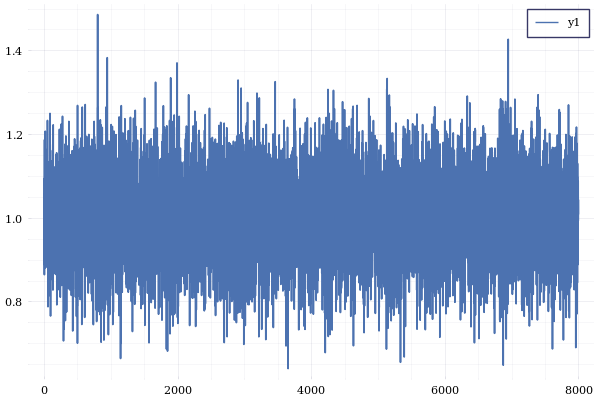

In [3]:
N = 8000
start_t1 = 800
start_t2 = 1800
Δf = 2e3
Nf = 15
fs = range(-Δf/2, Δf/2, length=Nf)
Ts = 8e-6

σ=0.1
d = Normal(0,σ)

y = 1 .+ rand(d, N) .+ j.*rand(d, N)
f_err = 0
sym_ferr = sym.*exp.(im*2*pi*f_err*Ts.* (1:length(sym)))
y[start_t1+1:start_t1+length(sym)] .+= sym_ferr
sym_ferr = sym.*exp.(im*2*pi*f_err*Ts.* (1:length(sym)))
y[start_t2+1:start_t2+length(sym)] .+= sym_ferr


start_t1 = 2900
start_t2 = 4200

f_err = 0
sym_ferr = sym.*exp.(im*2*pi*f_err*Ts.* (1:length(sym)))
y[start_t1+1:start_t1+length(sym)] .+= sym_ferr
sym_ferr = sym.*exp.(im*2*pi*f_err*Ts.* (1:length(sym)))
y[start_t2+1:start_t2+length(sym)] .+= sym_ferr

start_t1 = 5100
start_t2 = 6800

f_err = 0
sym_ferr = sym.*exp.(im*2*pi*f_err*Ts.* (1:length(sym)))
y[start_t1+1:start_t1+length(sym)] .+= sym_ferr
sym_ferr = sym.*exp.(im*2*pi*f_err*Ts.* (1:length(sym)))
y[start_t2+1:start_t2+length(sym)] .+= sym_ferr

plot(real.(y))

In [4]:
reg = zeros(2000) .|> Complex

function load(reg, data, i, N) 
    if mod(i,2) == 0
        x1 = 1
        x2 = N
    else
        x1 = N+1
        x2 = 2*N
    end
    reg[x1:x2] = data[N*i+1: N*(i+1)] 
    return reg
end

load (generic function with 1 method)

In [5]:
length(y)/1000

8.0

In [7]:
function window(reg, len, i)
    if i > len
        return reg[i-len+1:i]
    else
        return vcat(reg[length(reg)-len+i+1:end], reg[1:i])
    end
end


window (generic function with 1 method)

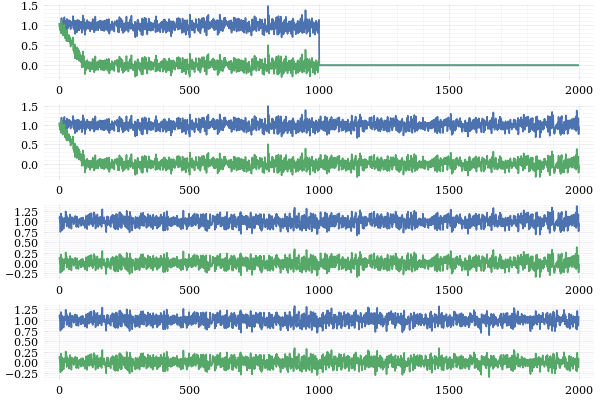

In [8]:
function fir(in_reg, fir_reg, i, M, N)
    if mod(i,2) == 0
        x1 = 1
        x2 = N
    else
        x1 = N+1
        x2 = 2*N
    end
    for j in x1:x2
        fir_reg[j] = in_reg[j] - mean(window(in_reg, M, j-1))
    end
    return fir_reg
end

in_reg = zeros(2000) .|> Complex
fir_reg = zeros(2000) .|> Complex

num_cycles = 4

p = repeat([plot()], num_cycles)

for i in 0:num_cycles-1
    in_reg = load(in_reg, y, i, 1000)
    p[i+1] = plot(real.(in_reg), xlabel="", ylabel="")
    fir_reg = fir(in_reg, fir_reg, i, 100, 1000)
    plot!(p[i+1], real.(fir_reg), xlabel="", ylabel="")
end

plot(p..., layout=(num_cycles,1), legend=false)


In [9]:
function noise_est(y)
    return norm(y.-mean(y))^2/(2*(length(y)-1))
end

function threshold(mmse_est, PFA, ref)
    return sqrt(-2*log(PFA)*mmse_est)*norm(ref)
end

threshold (generic function with 1 method)

In [10]:
function calc_noise(in_reg, noise_reg, i, N)
    if mod(i,2) == 0
        x1 = 1
        x2 = N
    else
        x1 = N+1
        x2 = 2*N
    end
    for k in x1:x2
        w = window(in_reg, length(ref), k)
        noise_reg[k] = noise_est(w)
    end
    return noise_reg
end

function calc_threshold(noise_reg, T_reg, i, PFA, ref, N)
    if mod(i,2) == 0
        x1 = 1
        x2 = N
    else
        x1 = N+1
        x2 = 2*N
    end
    for k in x1:x2
        j = mod(k-2*length(ref), 2*N)+1
        T_reg[k] = threshold(noise_reg[j], PFA, ref)
    end
    return T_reg
end

calc_threshold (generic function with 1 method)

In [11]:
Δf = 2e3
Ts = 8e-6
Nf = 9
ref = sym

fs = range(-Δf/2, Δf/2, length=Nf)

ns = 0:length(sym)-1

refs = hcat([exp.(2π*j*Ts*f.*ns).*ref for f in fs]...)

function short_correlate(y, refs)
    return hcat([abs(y'*r) for r in eachcol(refs)]...)
end

short_correlate (generic function with 1 method)

In [12]:
function calc_phi(in_reg, phi_reg, i, refs, N)
    if mod(i,2) == 0
        x1 = 1
        x2 = N
    else
        x1 = N+1
        x2 = 2*N
    end
    for j in x1:x2
        w = window(in_reg, length(ref), j)
        phi_reg[j,:] = short_correlate(w, refs)
    end
    return phi_reg
end

calc_phi (generic function with 1 method)

In [13]:
function delay_and_correlate(w)
    L = length(w)/2 |> Int
    return w[1:L]'*w[L+1:end]
end

function calc_dac(in_reg, dac_reg, i, N)
    if mod(i,2) == 0
        x1 = 1
        x2 = N
    else
        x1 = N+1
        x2 = 2*N
    end
    for j in x1:x2
        w = window(in_reg, length(ref), j)
        dac_reg[j] = delay_and_correlate(w)
    end
    return dac_reg
end

calc_dac (generic function with 1 method)

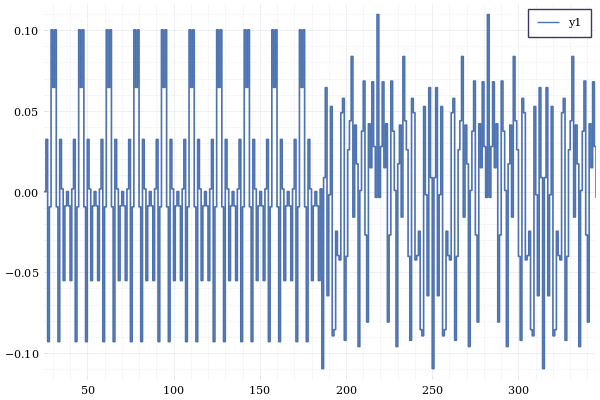

In [14]:
Nfft = 64
sym = freq_to_wave(S, Nfft)
sym = sym./norm(sym)
ref = sym

N = 800
start_t1 = 25
Δf = 0.2/Ts
Nf = 15
fs = range(-Δf/2, Δf/2, length=Nf)
Ts = 8/length(sym)*1e-6

σ=0.0
d = Normal(0,σ)

lsym = freq_to_wave(L,Nfft)
lsym = lsym ./ norm(lsym)

preamble = [sym..., lsym...]

y = rand(d, N) .+ j.*rand(d, N)
f_err = 0e3
sym_ferr = preamble.*exp.(im*2*pi*f_err*Ts.* (0:length(preamble)-1))
y[start_t1+1:start_t1+length(preamble)] .+= sym_ferr



plot(real.(y), xlim=(start_t1, start_t1+length(preamble)), line=:steppost)

In [15]:
fs[9]

1785.714285714286

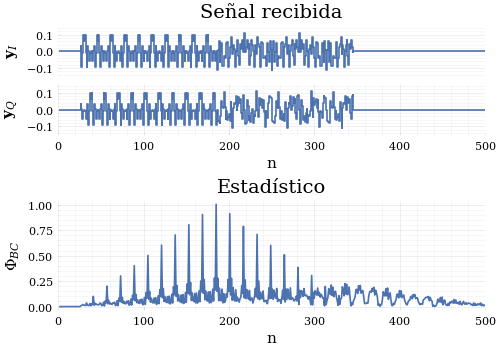

In [16]:
N = 250

in_reg = zeros(2*N) .|> Complex
fir_reg = zeros(2*N) .|> Complex
noise_reg = zeros(2*N)
T_reg = zeros(2*N)
phi_reg = zeros(2*N, Nf)
dac_reg = zeros(2*N) .|> Complex
det_reg = zeros(2*N, Nf)

num_cycles = 2

p1 = repeat([plot()], num_cycles)
p2 = repeat([plot()], num_cycles)
p3 = repeat([plot()], num_cycles)
p4 = repeat([plot()], num_cycles)

Δf = (0.0037.*Nf/2)/Ts
fs = range(-Δf/2, Δf/2, length=Nf)

ns = 0:length(sym)-1

refs = hcat([exp.(2π*j*Ts*f.*ns).*ref for f in fs]...)

PFA = 1e-6

for i in 0:num_cycles-1
    in_reg = load(in_reg, y, i, N)
    p1[i+1] = plot(real.(in_reg), xlabel="", ylabel="")
    fir_reg = fir(in_reg, fir_reg, i, 100, N)
    plot!(p1[i+1], real.(fir_reg), xlabel="", ylabel="")

    noise_reg = calc_noise(in_reg, noise_reg, i, N)
    p2[1+i] = plot(noise_reg, xlabel="", ylabel="")
    plot!(p2[i+1], [0, 2*N], [σ^2, σ^2], xlabel="", ylabel="")
    
    T_reg = calc_threshold(noise_reg, T_reg, i, PFA, ref, N)
    phi_reg = calc_phi(fir_reg, phi_reg, i, refs, N)
    p3[i+1] = plot(phi_reg[:,7], xlabel="", ylabel="")
    plot!(p3[i+1], T_reg, xlabel="", ylabel="")

    dac_reg = calc_dac(fir_reg, dac_reg, i, N)
end

idxs = 1:2*N


p1 = plot(real(in_reg), line=:steppost, ylim = (-0.15, 0.15), xlims=(0,2*N), xticks=[], yticks=[-0.1,0,0.1], ylabel=L"\mathbf{y}_I", title="Señal recibida")
p2 = plot(imag(in_reg), line=:steppost, ylim = (-0.15, 0.15), xlims=(0,2*N), xlabel="n", yticks=[-0.1,0,0.1], ylabel=L"\mathbf{y}_Q")
p12 = plot(p1,p2,layout=(2,1))
p3 = plot(phi_reg[:,8], xlabel="n", xlims=(0,2*N), ylabel=L"\Phi_{BC}", title="Estadístico")
plot(p12, p3, layout=(2,1), legend=false, size=imsize)

In [17]:
savefig("Defensa/Images/banco-xcorr1.pdf")

"/home/inox/Documents/IB/Tésis/Defensa/Images/banco-xcorr1.pdf"

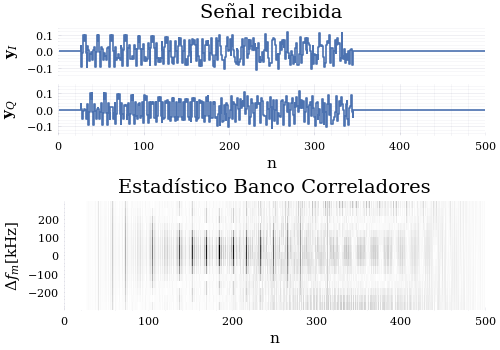

In [18]:
N = 800

d = Normal(0,0)
y = rand(d, N) .+ j.*rand(d, N)
f_err = 21e3
sym_ferr = preamble.*exp.(im*2*pi*f_err*Ts.* (0:length(preamble)-1))
y[start_t1+1:start_t1+length(preamble)] .+= sym_ferr

N = 250

in_reg = zeros(2*N) .|> Complex
fir_reg = zeros(2*N) .|> Complex
noise_reg = zeros(2*N)
T_reg = zeros(2*N)
phi_reg = zeros(2*N, Nf)
dac_reg = zeros(2*N) .|> Complex
det_reg = zeros(2*N, Nf)

num_cycles = 2

p1 = repeat([plot()], num_cycles)
p2 = repeat([plot()], num_cycles)
p3 = repeat([plot()], num_cycles)
p4 = repeat([plot()], num_cycles)

Δf = (0.0037.*Nf/2)/Ts
fs = range(-Δf/2, Δf/2, length=Nf)

ns = 0:length(sym)-1

refs = hcat([exp.(2π*j*Ts*f.*ns).*ref for f in fs]...)

PFA = 1e-6

for i in 0:num_cycles-1
    in_reg = load(in_reg, y, i, N)
    p1[i+1] = plot(real.(in_reg), xlabel="", ylabel="")
    fir_reg = fir(in_reg, fir_reg, i, 100, N)
    plot!(p1[i+1], real.(fir_reg), xlabel="", ylabel="")

    noise_reg = calc_noise(in_reg, noise_reg, i, N)
    p2[1+i] = plot(noise_reg, xlabel="", ylabel="")
    plot!(p2[i+1], [0, 2*N], [σ^2, σ^2], xlabel="", ylabel="")
    
    T_reg = calc_threshold(noise_reg, T_reg, i, PFA, ref, N)
    phi_reg = calc_phi(fir_reg, phi_reg, i, refs, N)
    p3[i+1] = plot(phi_reg[:,7], xlabel="", ylabel="")
    plot!(p3[i+1], T_reg, xlabel="", ylabel="")

    dac_reg = calc_dac(fir_reg, dac_reg, i, N)

    p4[i+1] = heatmap(1:2*N, fs, det_reg', xlabel="", ylabel="", colorbar=false)
end

idxs = 1:2*N


p1 = plot(real(in_reg), line=:steppost, ylim = (-0.15, 0.15), xlims=(0,2*N), xticks=[], yticks=[-0.1,0,0.1], ylabel=L"\mathbf{y}_I", title="Señal recibida")
p2 = plot(imag(in_reg), line=:steppost, ylim = (-0.15, 0.15), xlims=(0,2*N), xlabel="n", yticks=[-0.1,0,0.1], ylabel=L"\mathbf{y}_Q")
p12 = plot(p1,p2,layout=(2,1))
p3 = heatmap(idxs, fs.*1e-3, phi_reg', xlims=(0,2*N), xlabel="n", ylabel=L"\Delta f_m [\mathrm{kHz}]", title = "Estadístico Banco Correladores", c=:binary)
plot(p12, p3, layout=(2,1), legend=false, colorbar=false, size = imsize)

In [20]:
savefig("Defensa/Images/banco-xcorrN.pdf")

"/home/inox/Documents/IB/Tésis/Defensa/Images/banco-xcorrN.pdf"

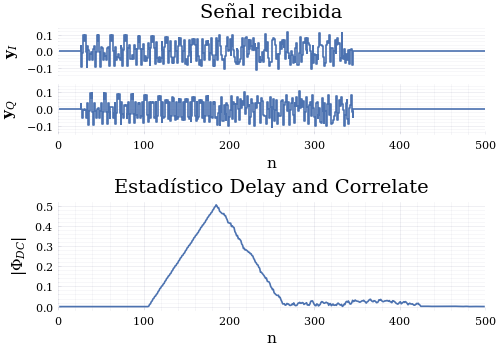

In [21]:
p3 = plot(idxs, abs.(dac_reg), xticks=[], xlims=(0,2*N), ylabel=L"|\Phi_{DC}|", title="Estadístico Delay and Correlate")
p4 = plot(idxs, angle.(dac_reg), xlabel="n", xlims=(0,2*N), ylabel=L"\angle\Phi_{DC}")
p34 = plot(p3,p4, layout=(2,1))
p33 = plot(p3, xlabel="n", xticks=0:100:500)
plot(p12, p33, layout=(2,1), legend=false, size=imsize)

In [22]:
savefig("Defensa/Images/delay-and-correlate-abs.pdf")

"/home/inox/Documents/IB/Tésis/Defensa/Images/delay-and-correlate-abs.pdf"

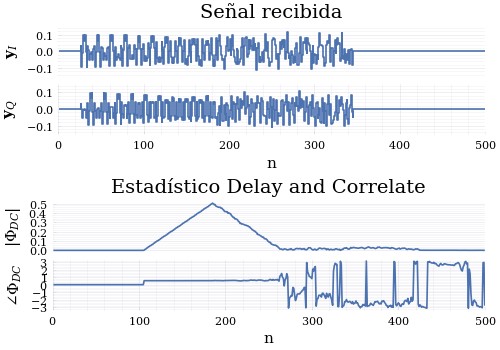

In [23]:
plot(p12, p34, layout=(2,1), legend=false, size=imsize)

In [24]:
savefig("Defensa/Images/delay-and-correlate-result.pdf")

"/home/inox/Documents/IB/Tésis/Defensa/Images/delay-and-correlate-result.pdf"

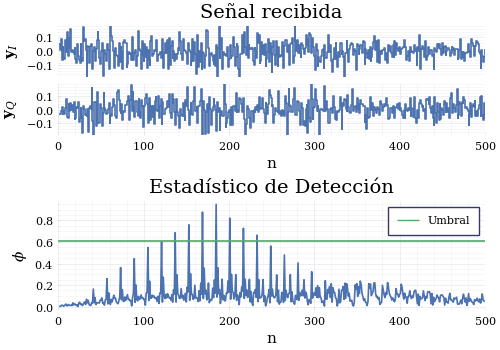

In [25]:
Nfft = 64
sym = freq_to_wave(S, Nfft)
sym = sym./norm(sym)
ref = sym

N = 800
start_t1 = 25
Δf = 0.2/Ts
Nf = 15
fs = range(-Δf/2, Δf/2, length=Nf)
Ts = 8/length(sym)*1e-6

σ=0.1
d = Normal(0,σ/2)

lsym = freq_to_wave(L,Nfft)
lsym = lsym ./ norm(lsym)

preamble = [sym..., lsym...]

y = rand(d, N) .+ j.*rand(d, N)
f_err = 0
snr=1
A = sqrt(2*length(sym)*snr)*σ/norm(sym)

sym_ferr = preamble.*exp.(im*2*pi*f_err*Ts.* (0:length(preamble)-1))
y[start_t1+1:start_t1+length(preamble)] .+= sym_ferr


N = 250

in_reg = zeros(2*N) .|> Complex
fir_reg = zeros(2*N) .|> Complex
noise_reg = zeros(2*N)
T_reg = zeros(2*N)
phi_reg = zeros(2*N, Nf)
dac_reg = zeros(2*N) .|> Complex
det_reg = zeros(2*N, Nf)

num_cycles = 2

p1 = repeat([plot()], num_cycles)
p2 = repeat([plot()], num_cycles)
p3 = repeat([plot()], num_cycles)
p4 = repeat([plot()], num_cycles)

Δf = (0.0037.*Nf/2)/Ts
fs = range(-Δf/2, Δf/2, length=Nf)

ns = 0:length(sym)-1

refs = hcat([exp.(2π*j*Ts*f.*ns).*ref for f in fs]...)

PFA = 1e-6

for i in 0:num_cycles-1
    in_reg = load(in_reg, y, i, N)
    p1[i+1] = plot(real.(in_reg), xlabel="", ylabel="")
    fir_reg = fir(in_reg, fir_reg, i, 100, N)
    plot!(p1[i+1], real.(fir_reg), xlabel="", ylabel="")

    noise_reg = calc_noise(in_reg, noise_reg, i, N)
    p2[1+i] = plot(noise_reg, xlabel="", ylabel="")
    plot!(p2[i+1], [0, 2*N], [σ^2, σ^2], xlabel="", ylabel="")
    
    T_reg = calc_threshold(noise_reg, T_reg, i, PFA, ref, N)
    phi_reg = calc_phi(fir_reg, phi_reg, i, refs, N)
    p3[i+1] = plot(phi_reg[:,7], xlabel="", ylabel="")
    plot!(p3[i+1], T_reg, xlabel="", ylabel="")

    dac_reg = calc_dac(fir_reg, dac_reg, i, N)

    p4[i+1] = heatmap(1:2*N, fs, det_reg', xlabel="", ylabel="", colorbar=false)
end

idxs = 1:2*N

function threshold(mmse_est, PFA, ref)
    return sqrt(-2*log(PFA))*mmse_est*norm(ref)
end
PFA = 1e-8

T = threshold(σ, PFA, ref)

p1 = plot(real(in_reg), legend=false, line=:steppost, ylim = (-0.18, 0.18), xlims=(0,2*N), xticks=[], yticks=[-0.1,0,0.1], ylabel=L"\mathbf{y}_I", title="Señal recibida")
p2 = plot(imag(in_reg), legend=false, line=:steppost, ylim = (-0.18, 0.18), xlims=(0,2*N), xlabel="n", yticks=[-0.1,0,0.1], ylabel=L"\mathbf{y}_Q")
p12 = plot(p1,p2,layout=(2,1))
p3 = plot(phi_reg[:,8], label=false, xlabel="n", xlims=(0,2*N), ylabel=L"\phi", title="Estadístico de Detección")
plot!([0,2*N],[T,T], label="Umbral", legend=:topright, title="Estadístico de Detección")
plot(p12, p3, layout=(2,1), size=imsize)

In [26]:
savefig("Defensa/Images/hipotesis.pdf")

"/home/inox/Documents/IB/Tésis/Defensa/Images/hipotesis.pdf"